In this notebook we check that for the two-qubit address register we can successfully retrieve one search solution. For Grover's search to be useful the number of search solutions should be less than half the size of the database. In order to check our strategy therefore we pose the question of preparing the state of the memory register pointing to the data '10' of the vector [1,0,7,10].
That is to say, if the state |1010> is contained in the location pointed by the memory register state |11> then we want the result of the quantum circuit to be |11>. 
In order to simplify our lives, we haven't changed the circuit corresponding to giving a negative phase to 1010 and 0101. We achieve this by simply not giving the entry '5' in the vector input. Otherwise, we could have easily incorporated the data entry '5' in the input vector by simply changing the readout register's coupling to ancilla. This is no real loss because we are simply interested in knowing whether our full circuit works as expected or not.

In [1]:
# initialization
import numpy as np

# import Qiskit
from qiskit import IBMQ, BasicAer , Aer, assemble , transpile
from qiskit.providers.ibmq import least_busy
from qiskit import QuantumCircuit, execute, QuantumRegister, ClassicalRegister
from qiskit.circuit.library import Permutation

# import basic plotting tools
from qiskit.visualization import plot_histogram
%matplotlib inline

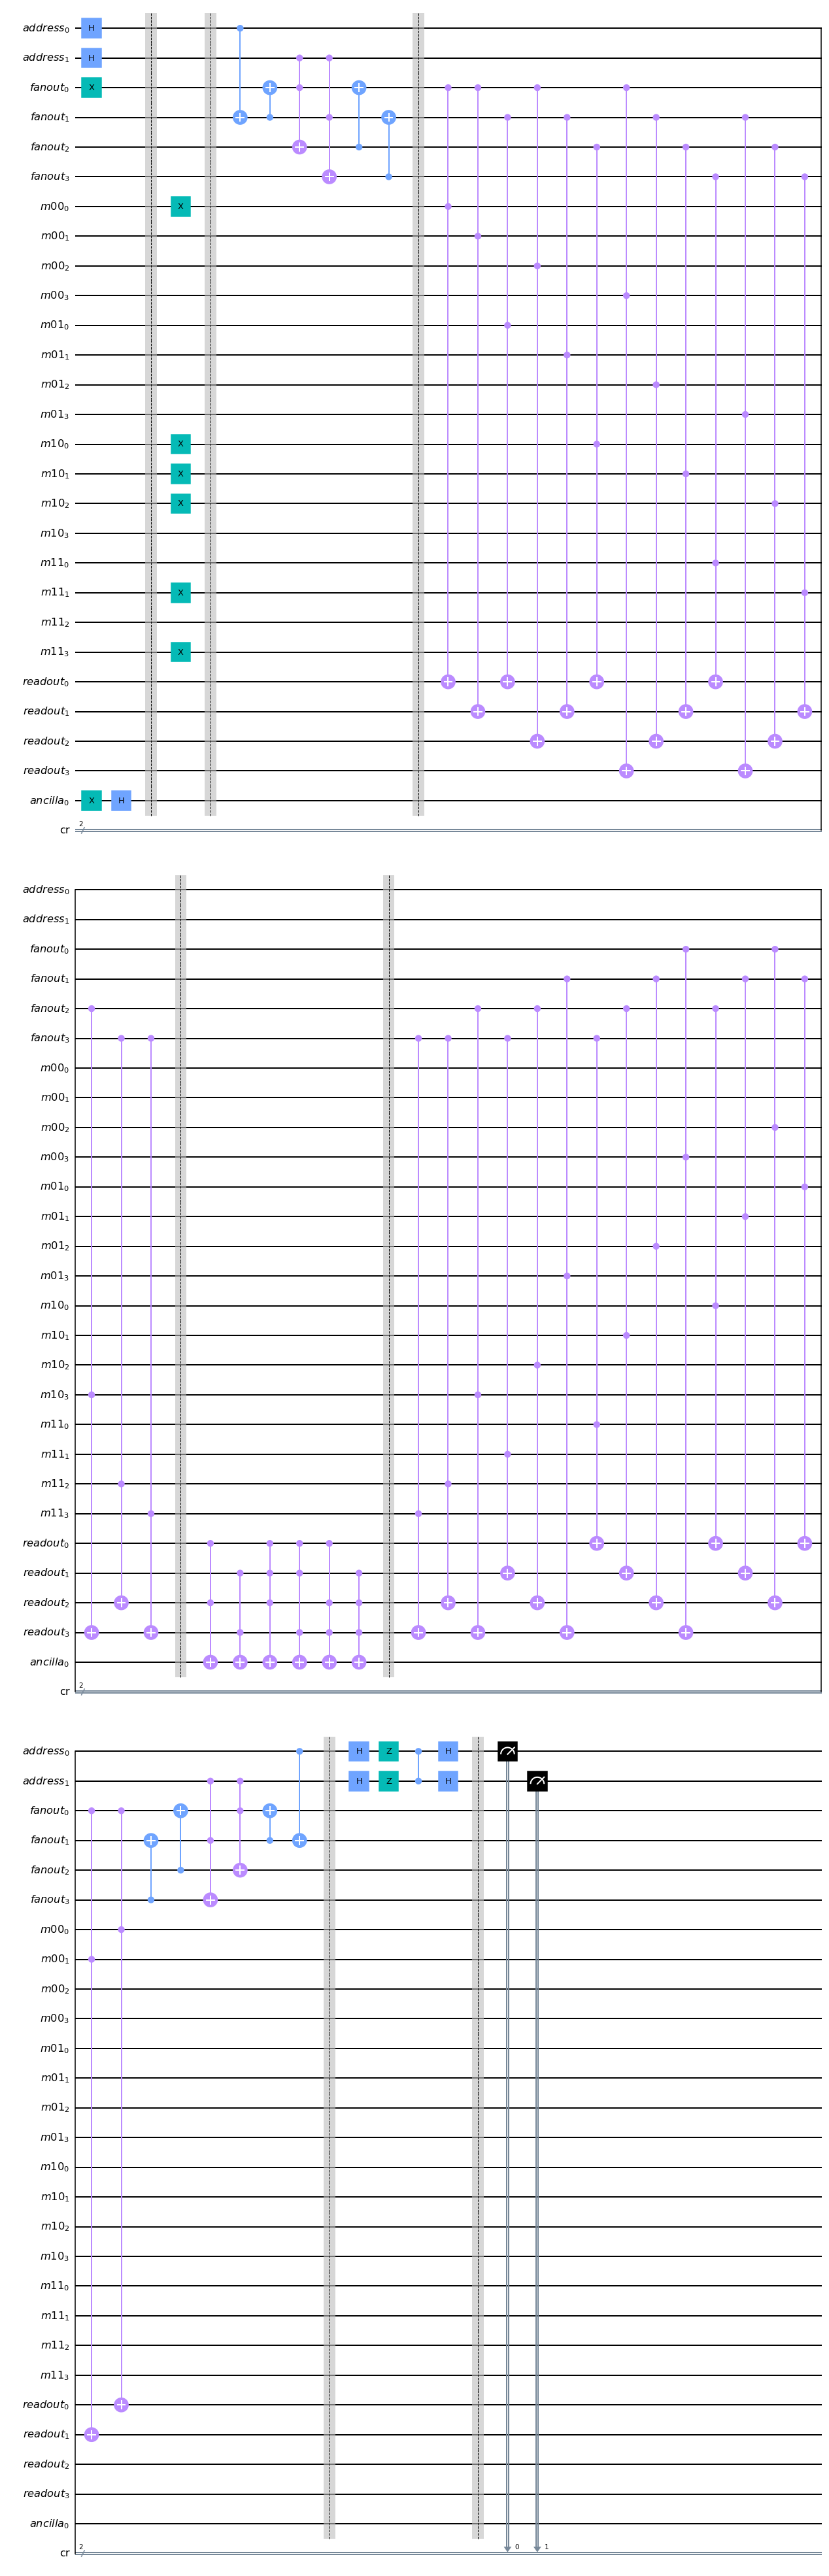

In [7]:
#qRAM circuit

ar = QuantumRegister(2, "address")   #address register
fo = QuantumRegister(4, "fanout")    # fanout register 
ro = QuantumRegister(4,"readout")     # readout register
anc = QuantumRegister(1,"ancilla")    #Ancilla to be used in the oracle

mr0 = QuantumRegister(4,"m00")   #Memory registers. Each one encodes a 4 bit data.
mr1 = QuantumRegister(4,"m01")
mr2 = QuantumRegister(4,"m10")
mr3 = QuantumRegister(4,"m11")
 
cr = ClassicalRegister(2,"cr")  #Classical register for the state of address register after one Grover iteration

qRAM = QuantumCircuit(ar,fo,mr0,mr1,mr2,mr3,ro,anc,cr)


#Initialize the first qubit of the fanout regsiter in the |1> state
qRAM.x(fo[0])

#Initialize the ancilla qubit in the |-> state
qRAM.x(anc[0])
qRAM.h(anc[0])

#Initialize the address register to get a uniform superposition of all the states, ie., SIGMA |x> for x = 0 to 3
qRAM.h(ar[0])
qRAM.h(ar[1])

qRAM.barrier()
##################################################################
#Feed in data to the memory register. Need a program to convert vector input to string input. For now
#we just do it by hand in the individual memory locations

#feed in integer 1 in mr0
qRAM.x(mr0[0])

#feed in integer 5 in mr1
#qRAM.x(mr1[0])
#qRAM.x(mr1[2])

#feed in integer 7 in mr2
qRAM.x(mr2[0])
qRAM.x(mr2[1])
qRAM.x(mr2[2])

#feed in integer 10 in mr3
qRAM.x(mr3[1])
qRAM.x(mr3[3])
##################################################################

qRAM.barrier()

#Fanout process
qRAM.cx(ar[0],fo[1])
qRAM.cx(fo[1],fo[0])
qRAM.mct([ar[1],fo[0]],fo[2])  #Multi-controlled Toffoli to implement CCX gate
qRAM.mct([ar[1],fo[1]],fo[3])
qRAM.cx(fo[2],fo[0])
qRAM.cx(fo[3],fo[1])

qRAM.barrier()

#Readout process
qRAM.mct([fo[0],mr0[0]],ro[0])
qRAM.mct([fo[0],mr0[1]],ro[1])
qRAM.mct([fo[0],mr0[2]],ro[2])
qRAM.mct([fo[0],mr0[3]],ro[3])



qRAM.mct([fo[1],mr1[0]],ro[0])
qRAM.mct([fo[1],mr1[1]],ro[1])
qRAM.mct([fo[1],mr1[2]],ro[2])
qRAM.mct([fo[1],mr1[3]],ro[3])



qRAM.mct([fo[2],mr2[0]],ro[0])
qRAM.mct([fo[2],mr2[1]],ro[1])
qRAM.mct([fo[2],mr2[2]],ro[2])
qRAM.mct([fo[2],mr2[3]],ro[3])


qRAM.mct([fo[3],mr3[0]],ro[0])
qRAM.mct([fo[3],mr3[1]],ro[1])
qRAM.mct([fo[3],mr3[2]],ro[2])
qRAM.mct([fo[3],mr3[3]],ro[3])

qRAM.barrier()

## Now we do two-qubit Toffolis on the readout register to mark the states 0101 and 1010
# However, it marks other states too that would be taken care of shortly using four qubit Toffoli gates.
qRAM.mct([ro[0],ro[2]],anc[0])  
qRAM.mct([ro[1],ro[3]],anc[0])

#Four qubit Toffolis make sure that no other states except 0101 and 1010 remain marked.
#By marked we mean that the 0101 and 1010 give a negative phase to the ancilla: |-> --> -|->, while
# the other states do not change the ancilla.
qRAM.mct([ro[0],ro[1], ro[2]],anc[0])  
qRAM.mct([ro[0],ro[1], ro[3]],anc[0])  
qRAM.mct([ro[0],ro[2], ro[3]],anc[0])  
qRAM.mct([ro[1],ro[2], ro[3]],anc[0])  

qRAM.barrier()

#Diffuser will be applied to the address register after the uncomputation


#~~~~~~~~ Now we need to uncompute ~~~~~~~~~
## Uncompute the readout
qRAM.mct([fo[3],mr3[3]],ro[3])
qRAM.mct([fo[3],mr3[2]],ro[2])
qRAM.mct([fo[3],mr3[1]],ro[1])
qRAM.mct([fo[3],mr3[0]],ro[0])

qRAM.mct([fo[2],mr2[3]],ro[3])
qRAM.mct([fo[2],mr2[2]],ro[2])
qRAM.mct([fo[2],mr2[1]],ro[1])
qRAM.mct([fo[2],mr2[0]],ro[0])

qRAM.mct([fo[1],mr1[3]],ro[3])
qRAM.mct([fo[1],mr1[2]],ro[2])
qRAM.mct([fo[1],mr1[1]],ro[1])
qRAM.mct([fo[1],mr1[0]],ro[0])

qRAM.mct([fo[0],mr0[3]],ro[3])
qRAM.mct([fo[0],mr0[2]],ro[2])
qRAM.mct([fo[0],mr0[1]],ro[1])
qRAM.mct([fo[0],mr0[0]],ro[0])


##Uncompute the fanout
qRAM.cx(fo[3],fo[1])
qRAM.cx(fo[2],fo[0])
qRAM.mct([ar[1],fo[1]],fo[3])
qRAM.mct([ar[1],fo[0]],fo[2]) 
qRAM.cx(fo[1],fo[0])
qRAM.cx(ar[0],fo[1])

qRAM.barrier()

#Now we apply the two-qubit diffuser to the address register
qRAM.h(ar[0])
qRAM.h(ar[1])
qRAM.z(ar[0])
qRAM.z(ar[1])
qRAM.cz(ar[0],ar[1])
qRAM.h(ar[0])
qRAM.h(ar[1])

qRAM.barrier()

## Measure the address register to see the states
qRAM.measure(ar[0],cr[0])
qRAM.measure(ar[1],cr[1])

qRAM.draw()



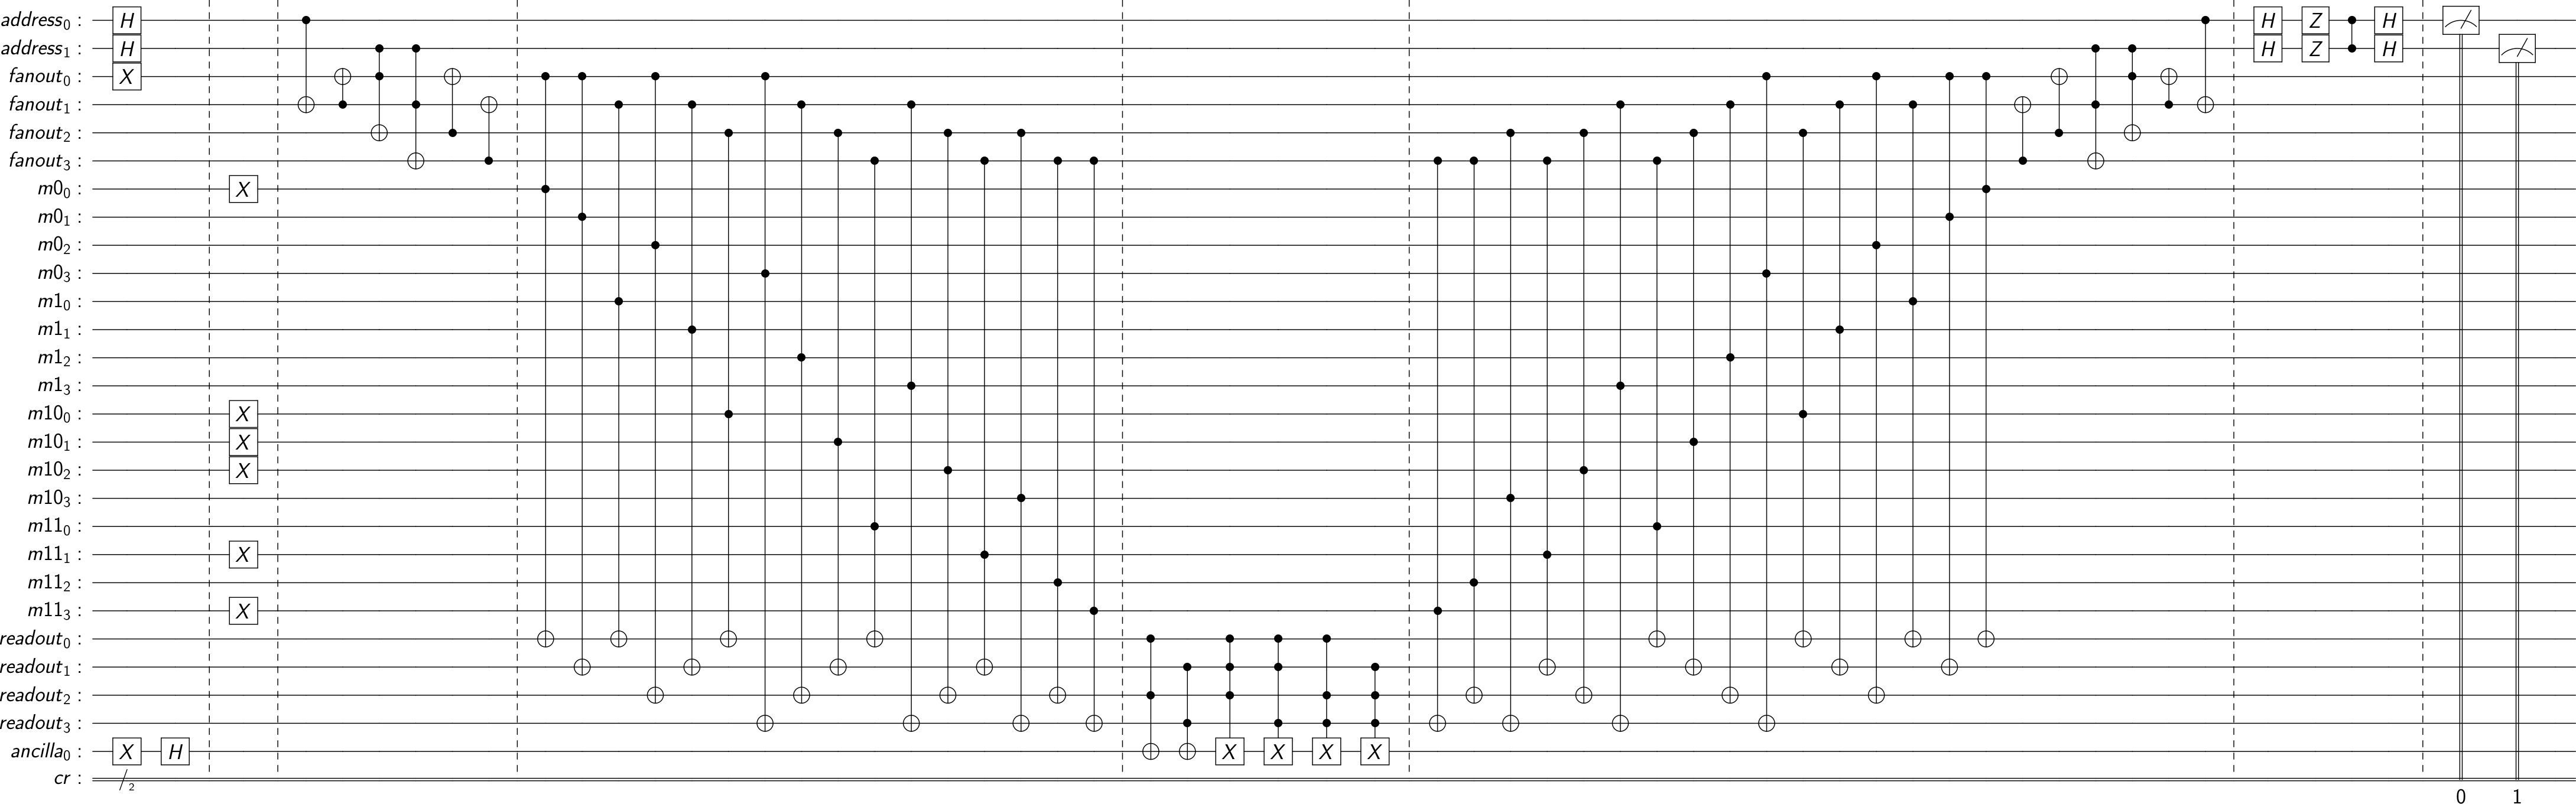

In [8]:
from qiskit.tools.visualization import circuit_drawer
circuit_drawer(qRAM, scale=None, filename=None, style=None, output='latex', interactive=False, plot_barriers=True, reverse_bits=False, justify=None, vertical_compression='high', idle_wires=True, with_layout=True, fold=None, ax=None, initial_state=False, cregbundle=True)

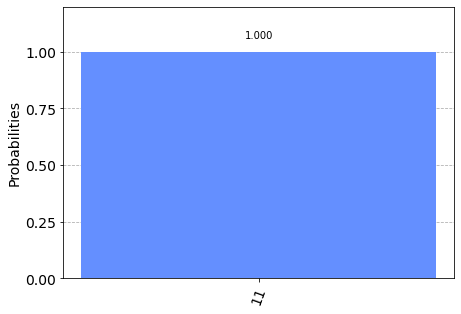

In [4]:

simulator = Aer.get_backend('qasm_simulator')
qRAM = transpile(qRAM,simulator)
qobj = assemble(qRAM)
result = simulator.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)


In [5]:
Aer.backends()

[QasmSimulator(
 backend_name='qasm_simulator', provider=AerProvider()),
 StatevectorSimulator(
 backend_name='statevector_simulator', provider=AerProvider()),
 UnitarySimulator(
 backend_name='unitary_simulator', provider=AerProvider()),
 PulseSimulator(
 backend_name='pulse_simulator', provider=AerProvider())]